# Helmet Classification For TinyML Project

> 이 notebook 은 open source 컨트리뷰톤 2020 - tinyML (Tensorflow Lite Project) Mobility Team 의 오픈소스 프로젝트를 위해 만들어졌습니다. 

- 모빌리티 팀 (멘토 맹윤호)
- 최예진(팀장), 이민우, 전수민, 이장후, 이경환, 조승현
- **.ipynb 제작 - 이장후. 2020/08/29**
- **.ipynb 수정자 -**

<br>

- Target Github Repository : [TinyML : Tensorflow lite for microcontroller](https://github.com/yunho0130/tensorflow-lite)
- Team Github Repository : [TinyML-Mobility](https://github.com/orgs/tinyml-mobility/teams)

<br>

## Before We Start
- 런타임 -> GPU 로 변경 하셨나요?

<br>

## This Time
- 생성된 h5 모델을 불러들여 tflite 파일로 변환해 봅시다.
- 구현된 모델을 조금 수정하면서, Class Activation Map* 을 한번 visualization 해 봅시다.

*Class Activation Map 이란, Helmet 클래스로 판단하는 데 어떤 부분을 가장 주목해서 보았는지와 같이, 어떤 클래스로 판단하는 것의 근거를 Visualization 한 이미지를 의미합니다. 


# Google Drive

- 학습을 시키기 전 데이터가 있는 google Drive 와 연동을 해야 합니다.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Include Library

- 이 노트북의 소스코드는 tensorflow 2.0 이상과 호환되지 않습니다.
- Google colab 에서는 %tensorflow_version 을 통해, 원하는 버전의 tensorflow 를 쉽게 불러올 수 있습니다

In [2]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

# tensorflow 는 기본적으로, "정적 그래프 형식" 으로 실행하여 그때그때 실행해서 결과를 찍어보는 것이 불가능합니다.
# tf.enable_eager_execution 을 실행해 주어야, datagen 으로 실행이 가능합니다.
# 이 코드는, 
tf.enable_eager_execution()


import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [3]:
tf.__version__

'1.15.2'

# Overview

## TinyML
- 모델을 .tflite 파일로 변환하기 위해 tensorflow lite 의 python API 를 활용할 것입니다.
- .tflite 는 플랫버퍼 형식이라고 합니다.
- 플랫버퍼 형식에 대한 장점은 굉장히 많다고 하지만, 저를 포함해서 이 튜토리얼을 진행하는 분들에게는 너무 어려운 내용일 것입니다. 그냥 "효율적인 자료 저장 형식이다" 라고 생각합시다!


## Optimization
- 우리는 지금 "작은 모델을 만들기 위해" part3 으로 넘어왔습니다.
- 우리가 다음 작업을 진행하기 전에, 확인해야 할 큰 그림이 있습니다. 이 내용은 tinyML 책 챕터 15에 자세히 나와 있습니다. 이를 간단히 이야기해보도록 해요.

<br>

**Hardware Selection**
- 주머니 사정과 성능, 접근성 및 개발 속도를 모두 고려하여 하드웨어를 선택해야 합니다.
- 저희는 이 프로젝트를 진행하며, 파일을 Raspberry Pi 4에 업로드할 것입니다.
- Raspberry Pi 4 는 단돈 5만원에 매우 강력한 성능을 자랑하는 컴퓨터로, 비영리 재단에서 만든 소형 컴퓨터입니다.
- Raspberry Pi 4 는 일반적인 마이크로컨트롤러들과 달리, 운영체제가 올라가고 메모리와 디스크 모두 넉넉합니다.
- 라즈베리파이는 운영체제가 올라가는 컴퓨터이기 때문에, high level language 인 python 을 설치할 수 있습니다. tensorflow lite 모델을 사용하기 위해, 복잡한 C++ API 를 사용하는 것이 아니라, tensorflow lite python API 를 사용할 수 있습니다.
- Raspberry Pi 4 는 다양한 주변기기를 연결할 수 있도록 지원하고, 저희는 종내에 소형 GPU 를 사용해서 모델을 돌려 볼 수 있도록 할 것입니다.

<br>

**Model Selection**
- 우리는 헬멧 인식 모델을 만들 것이고, 헬멧을 착용하기 위한 모델은 굉장히 복잡합니다.
- 소형 기기에 배포하기 위해 이 모델을 가볍게 만드는 것은 전력 소비 / 실행 속도 / 이용자 체감 에서도 매우 중요한 이슈겠지요.
- 우리는 tinyML 책에서 제시된 MobileNet v1 보다 효율적인 MobileNet v2 를 사용했습니다.
- 일반적인 CNN 모델들보다 훨씬 효율적인 모델입니다.

<br>

**Quantization**
- 많은 임베디드 디바이스에서는 소수점 연산에 어려움을 겪습니다!
- 정수 연산보다 훨씬 오랜 시간이 걸리는 것도 사실입니다.
- 오늘 할 작업은, 32비트 소수 가중치, 32비트 소수 input 등을 통해 이루어지고 있던 모델의 추론을, 모두 정수 형태로 바꾸어내는 것입니다.
- 이를 양자화 (quantization) 이라고 합니다.





In [5]:
%cd /content/gdrive/"My Drive"/data/

# 데이터가 존재하는 경로 ( /content/gdrive/"My Drive"/data/helmetclassification ) 를 data_dir 변수에 저장합니다.
data_dir = os.path.join(os.getcwd(), 'helmetclassification')
print(data_dir)

# 우리는 part1 과 part2 에서 input 이미지의 크기를 128 by 128 by 3 으로 설정했습니다. 채널은 변함없이 RGB 이므로, 3 입니다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

# 연산 처리 단위 (배치) 는 이미지 32장, 그리고 Learning Rate, optimizer, 에폭 등을 설정합니다.
BATCH_SIZE = 32

# 우리는 checkpoint 를 설정해서, 각 epoch 마다 가중치를 저장할 것입니다.
CKPT_DIR = os.path.join(data_dir, 'checkpoint')

# 우리는 h5 file 을 tflite 파일로 전환할 것입니다. 우리가 저장했던 이름을 미리 등록해 둡시다.
# SAVED_KERAS_MODEL_NAME = 'helmet_classification_model.h5'                     # part1 을 통해 만들어진 h5 파일을 사용하는 경우
SAVED_KERAS_MODEL_NAME = 'helmet_classification_model_handmaded_mobilenet.h5' # part2 를 통해 만들어진 h5 파일을 사용하는 경우

# 이번에 우리는 h5 file 을 읽어와 tflite 파일로 바꾸어 저장할 것입니다. 이름을 미리 정해 둡시다.
# SAVED_TFLITE_MODEL_NAME = 'helmet_classification_model.tflite'                    # part1 을 통해 만들어진 h5 파일로부터 tflite 파일을 만들어내는 경우
SAVED_TFLITE_MODEL_NAME = 'helmet_classification_model_handmaded_mobilenet.tflite' # part2 를 통해 만들어진 h5 파일로부터 tflite 파일을 만들어내는 경우


# 우리가 저장했던 라벨 파일의 이름입니다.
LABEL_FILE_NAME = 'ishelmetlabel.txt'

/content/gdrive/My Drive/data
/content/gdrive/My Drive/data/helmetclassification


# Quantization

## Idea
- 어떤 작업인지는 위에서 설명했습니다.
- Quantization 을 수행하기 위해서는, 학습한 데이터셋의 입력값 범위를 나타내는 숫자의 집합인 대표 예시 데이터셋을 만들어 넣어 주어야 합니다.
- 그 이유는 우리가

## How to
- 예시 데이터를 만들어 줄 수 있는 generator

In [5]:
%cd /content/gdrive/"My Drive"/data/helmetclassification
%ls
converter = tf.lite.TFLiteConverter.from_keras_model_file(SAVED_KERAS_MODEL_NAME)

/content/gdrive/My Drive/data/helmetclassification
checkpoint/  helmet_classification_model_handmaded_mobilenet.h5  test/  train/
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# 양자화를 포함해서, 기본 최적화를 진행합니다.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 예시 데이터를 가져다주어야 한다고 했습니다.

def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data_dir + '/test' + '/*/*')
  print('dataset_list : ', dataset_list)
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

# 무슨 값이 들어있나 궁금하면 출력해 보세요.
# im = representative_data_gen()
# print(next(im))

# converter 객체에 등록해 줍니다.
converter.representative_dataset = representative_data_gen


# 실제값 = (int8변환값 - 영점) * scale
# int8변환값 = 실제값 / scale + 영점
# input 은 float 이든 int 이든, 어차피 255 배 커지는건데 뭔상관?!
# 255배 크게 활성화되든 작게 활성화되든 이미 training 은 끝났거든~~
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# 아래 주석처리된 소스코드는, INT8 로 전환할 때, 양자화를 지원하지 않는 operation 이 있는지 없는지 확인해 볼 수 있습니다.
# 원래 CORAL 과 같은 int8 자료형만을 지원하는 디바이스에 업로드하기 위해서는 아래 코드를 활성화해야 합니다.
# 모델을 직접 만드는 경우, 아직 mobilenet 의 모든 기능을 구현할 수 있도록 operation 이 support 되지 않을 수 있습니다.
# 동일한 모델을 만들더라도, 다른 operation 을 활용해서 만들 수 있기 때문입니다.
# handmaded (part2 에서 만들어낸 모델) 모델을 활용해서 convert 할 경우에는, 아래 코드를 주석처리 해 주세요.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [11]:
# 변환된 객체를 tflite_model 변수에 저장합니다.
tflite_model = converter.convert()

dataset_list :  <DatasetV1Adapter shapes: (), types: tf.string>


In [22]:
%cd /content/gdrive/"My Drive"/data/helmetclassification

# 파일을 저장합니다.
open(SAVED_TFLITE_MODEL_NAME, "wb").write(tflite_model)

/content/gdrive/My Drive/data/helmetclassification


1251960

# Class Activation Mapping
- reference : [keras code example](https://keras.io/examples/vision/grad_cam/)

In [6]:
%cd /content/gdrive/"My Drive"/data/helmetclassification
%ls
full_model = tf.keras.models.load_model(SAVED_KERAS_MODEL_NAME)
full_model.summary()

/content/gdrive/My Drive/data/helmetclassification
checkpoint/
helmet_classification_model_handmaded_mobilenet.h5
helmet_classification_model_handmaded_mobilenet.tflite
helmet_classification_model.tflite
test/
train/
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]   

In [18]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name="Conv_1", classifier_layer_names=["global_average_pooling2d", "Logits",],  class_select='argmax'
    ):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    # 텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것. 쉽게 말하면 매개변수 미분, 연쇄법칙)을 위한 tf.GradientTape API를 제공합니다. 
    # tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 
    # 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer 
        last_conv_layer_output = last_conv_layer_model(img_array)
        # and make the tape watch it
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        print('prediction tensor shape : ', preds.shape) # (1,2)
        print('prediction : ', preds[0])
        if class_select == 'argmax' :
          class_index_to_visualize = tf.argmax(preds[0])
          print('prediction argmax : ', class_index_to_visualize, 'type : ', type(class_index_to_visualize)) # Tensor(1,)
        else :
          # 0 : wearing a helmet
          # 1 : not wearing helmet
          class_index_to_visualize = tf.convert_to_tensor(class_select, dtype='int64')

        class_channel = preds[:, class_index_to_visualize]
        print('prediction prediction channel : ', class_channel)

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # 구한 gradient 들의 채널들 평균이 해당 위치의 gradient 라는 것 같은데..
    # axis 를 왜 저따구로 쓴거지..? 그냥 axis = 0 하면 안되는건가?
    # 일단 두번째 저 axis 순서대로 reduce 하는 것임은 확인. axis 0 >> axis 1 >> axis 2
    # axis 0 은 batch wise 인데 어차피 batch size 1 이니까, channel last 인 tensorflow 특성상, row 로 평균내고, col 로 평균내면, channel 만 남게 됨. 즉 channel 당 1개.
    # 그럼 channel 당 1개라는건 그냥 특정 channel 의 중요도를 나타내게 됨. 즉, channel 의 weight 을 의미하게 됨.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]): # 모든 채널에 대해서 곱하겠다는 뜻인데 더럽게도 어렵게 써놨네 는 무슨 내가 이해할수라도 있어서 너무 다행이다.
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

자 이제 함수를 다 만들었습니다! 다음 셀에서는 다음과 같은 작업을 진행합니다.
- PIL 라이브러리를 활용해서 helmet 을 차고 있는 test set 에서 random 한 image 하나 가져오기
- PIL 라이브러리를 활용해서 helmet 을 차고 있지 않은 test set 에서 random 한 image 하나 가져오기
- PIL 로 가져온 것을 numpy array 로 바꾸고, matplotlib.pyplot 의 imshow() 로 이미지 잘 가져왔나 확인 해보기

In [9]:
import PIL
import numpy as np
import os

# load the image
helmet_test_path = os.path.join(data_dir, "test", "helmet")
helemt_test_img_list = os.listdir(helmet_test_path)
nonhelmet_test_path = os.path.join(data_dir, "test", "non_helmet")
nonhelemt_test_img_list = os.listdir(nonhelmet_test_path)

좌 : <class 'numpy.ndarray'>
좌 : (44, 36, 3)
우 : <class 'numpy.ndarray'>
우 : (218, 178, 3)


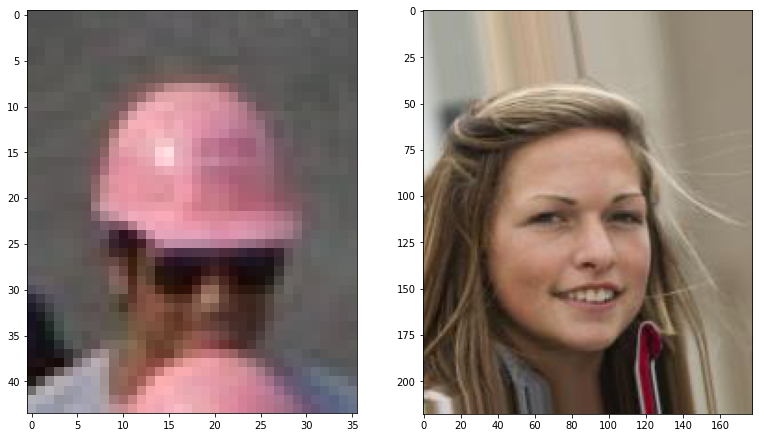

In [40]:
import random
helmet_image_path = os.path.join(data_dir, "test", "helmet", random.choice(helemt_test_img_list))
nonhelmet_image_path = os.path.join(data_dir, "test", "non_helmet", random.choice(nonhelemt_test_img_list))

helmet_image = PIL.Image.open(helmet_image_path)
nonhelmet_image = PIL.Image.open(nonhelmet_image_path)

# convert image to numpy array
helmet_npimage = np.asarray(helmet_image)
nonhelmet_npimage = np.asarray(nonhelmet_image)

print('좌 :',type(helmet_npimage))
print('좌 :',helmet_npimage.shape)
print('우 :',type(nonhelmet_npimage))
print('우 :',nonhelmet_npimage.shape)

import matplotlib.pyplot as plt
plt.figure(figsize = [13,8])
plt.subplot(1,2,1) # (행, 열, 첫번째) - 자세한 내용은 plt.subplot() 을 참고하세요.
plt.imshow(helmet_npimage)
plt.subplot(1,2,2) # (행, 열, 두번째) - 자세한 내용은 plt.subplot() 을 참고하세요.
plt.imshow(nonhelmet_npimage)

좌 : <class 'numpy.ndarray'>
좌 : (128, 128, 3)
우 : <class 'numpy.ndarray'>
우 : (128, 128, 3)


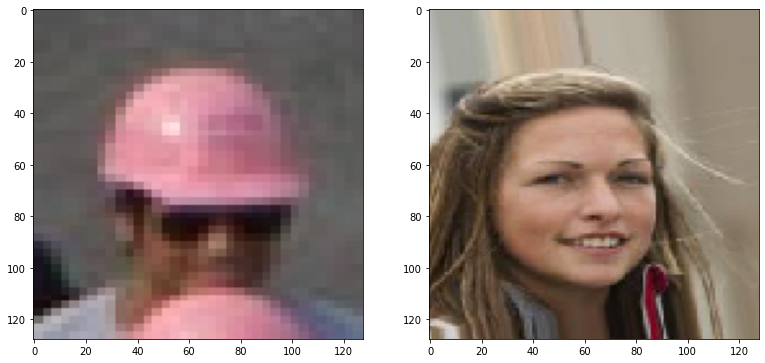

In [41]:
# 참고로 PIL 모듈을 활용해 만들어진 keras 함수가 이미 존재해서, PIL 을 사용하지 않고 사용할 수도 있습니다.
# 이 경우에, 불러오는 동시에 target_size 를 지정함으로써 다양한 속성을 지정해 직관적으로 이미지를 불러올 수 있습니다.
helmet_image_from_keras = tf.keras.preprocessing.image.load_img(
    helmet_image_path, grayscale=False, color_mode='rgb', target_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest'
)

nonhelmet_image_from_keras = tf.keras.preprocessing.image.load_img(
    nonhelmet_image_path, grayscale=False, color_mode='rgb', target_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest'
)

# convert image to numpy array
helmet_npimage_from_keras = tf.keras.preprocessing.image.img_to_array(helmet_image_from_keras) / 255.
nonhelmet_npimage_from_keras = tf.keras.preprocessing.image.img_to_array(nonhelmet_image_from_keras) / 255.

# helmet_npimage_from_keras = np.asarray(helmet_image_from_keras)
# nonhelmet_npimage_from_keras = np.asarray(nonhelmet_image_from_keras)

print('좌 :',type(helmet_npimage_from_keras))
print('좌 :',nonhelmet_npimage_from_keras.shape)
print('우 :',type(helmet_npimage_from_keras))
print('우 :',nonhelmet_npimage_from_keras.shape)


plt.figure(figsize = [13,8])
plt.subplot(1,2,1) # (행, 열, 첫번째) - 자세한 내용은 plt.subplot() 을 참고하세요.
plt.imshow(helmet_npimage_from_keras)
plt.subplot(1,2,2) # (행, 열, 두번째) - 자세한 내용은 plt.subplot() 을 참고하세요.
plt.imshow(nonhelmet_npimage_from_keras)
# 이 경우에, reshape 를 하면서 약간 찌그러진 모습이 보일 수 있습니다.

helmet image
prediction tensor shape :  (1, 2)
prediction :  tf.Tensor([9.9999988e-01 1.3603075e-07], shape=(2,), dtype=float32)
prediction prediction channel :  tf.Tensor([0.9999999], shape=(1,), dtype=float32)

nonhelmet image
prediction tensor shape :  (1, 2)
prediction :  tf.Tensor([1.6570584e-13 1.0000000e+00], shape=(2,), dtype=float32)
prediction prediction channel :  tf.Tensor([1.], shape=(1,), dtype=float32)


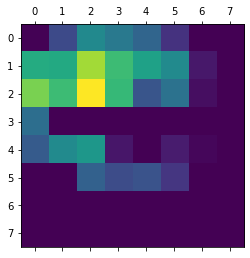

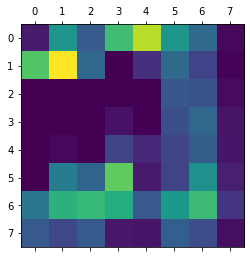

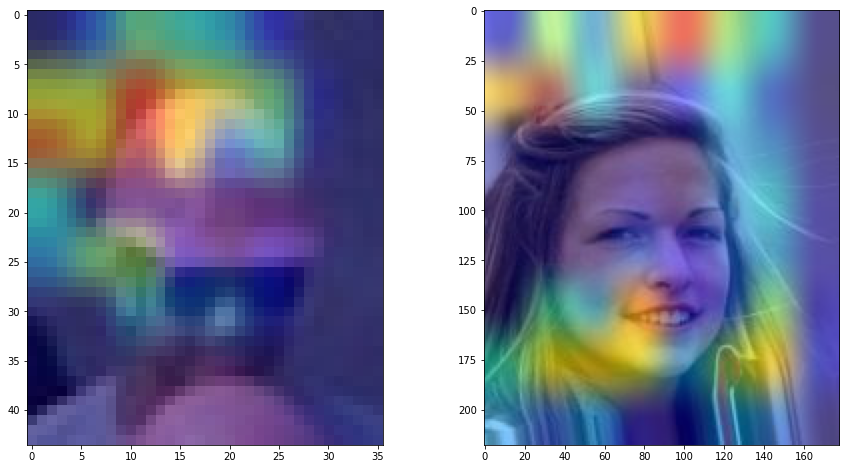

In [42]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 160, 160
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (160, 160, 3)
    array = tf.keras.preprocessing.image.img_to_array(img) / 255.
    # We add a dimension to transform our array into a "batch"
    # of size (1, 160, 160, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_helmet = get_img_array(helmet_image_path, (IMG_WIDTH, IMG_HEIGHT))
img_nonhelmet = get_img_array(nonhelmet_image_path, (IMG_WIDTH, IMG_HEIGHT))
print('helmet image')
heatmap_helmet = make_gradcam_heatmap(img_helmet, full_model, 
                                      # 아래 두 줄의 코드는, part2 에서 직접 만든 모델을 돌릴 때 사용하세요.
                                      'final_conv', 
                                      ['global_average_pooling2d', 'dense'],
                                      class_select = 0
                                      )
print('\nnonhelmet image')
heatmap_nonhelmet = make_gradcam_heatmap(img_nonhelmet, full_model, 
                                         'final_conv', 
                                         ['global_average_pooling2d', 'dense'],
                                         class_select = 1
                                         )

# Display heatmap
plt.matshow(heatmap_helmet)
plt.matshow(heatmap_nonhelmet)

img_original = tf.keras.preprocessing.image.load_img(helmet_image_path)
img_original = tf.keras.preprocessing.image.img_to_array(img_original)
nonhelmet_img_original = tf.keras.preprocessing.image.load_img(nonhelmet_image_path)
nonhelmet_img_original = tf.keras.preprocessing.image.img_to_array(nonhelmet_img_original)

# We rescale heatmap to a range 0-255
heatmap_helmet = np.uint8(255 * heatmap_helmet)
heatmap_nonhelmet = np.uint8(255 * heatmap_nonhelmet)

# We use jet colormap to colorize heatmap
import matplotlib
jet = matplotlib.cm.get_cmap("jet")
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]

# color map 에 color 을 대응시켜주는 코드입니다. 예를 들어 숫자가 클수록 붉은 색이 되는 color map 이 있을테고, 숫자가 커지는순간 0 이 돼버리는 color map 등 다양한 color map 이 있는데,
# 내가 가진 어떤 값을 어떤 색상으로 대응시킬 것인지 골라주는 역할이라고 할 수 있지요.
# 우리가 선택한 것은, RGB map 입니다. heatmat 을 RGB 채널에 대응되도록 만들어 줍니다.
jet_heatmap = jet_colors[heatmap_helmet]
jet_nonhelmet_heatmap = jet_colors[heatmap_nonhelmet] 

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_original.shape[1], img_original.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

jet_nonhelmet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_nonhelmet_heatmap)
jet_nonhelmet_heatmap = jet_nonhelmet_heatmap.resize((nonhelmet_img_original.shape[1], nonhelmet_img_original.shape[0]))
jet_nonhelmet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_nonhelmet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.8 + img_original
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

nonhelmet_superimposed_img = jet_nonhelmet_heatmap * 0.8 + nonhelmet_img_original
nonhelmet_superimposed_img = tf.keras.preprocessing.image.array_to_img(nonhelmet_superimposed_img)

# Display Grad CAM
plt.figure(4, figsize = [15,8])
plt.subplot(1,2,1)
plt.imshow(superimposed_img)
plt.subplot(1,2,2)
plt.imshow(nonhelmet_superimposed_img)

# Next Time
데이터의 편향이 크고, 모델이 불안정한 경향을 보여 예쁜 결과와 멋진 정확도는 얻기 어려웠습니다. 그럼에도 대체적으로, 헬멧의 착용유무를 판단하는 것에 머리 윗부분을 확인한다는 것을 알 수 있었습니다.

결과가 지나치게 신뢰할 수 없다면, 학습 상태를 다시 확인해 보고, 재학습을 하는 것 - 모델을 변경하는 것 - 데이터를 다시 수정하는 것 등이  해결책이 될 것입니다.
특히, 공사장에서 촬영한 사진들로부터 헬멧과 증명사진을 두고 학습시킨 모델은, 배경에서부터 크게 차이가 날수밖에 없습니다. 이는 우리의 문제상황에 완벽하게 알맞은 데이터가 아닙니다. 우리의 상황에 알맞게 Fine Tuning 하는 과정이 필요합니다.

하지만 우리는 나아갈 길이 멀고, 기나긴 과정을 거쳐 왔습니다. 지금까지 흘러온 프로세스를 반복하며 결과를 개선하는 일은 여러분께 맡기겠습니다. 수고했습니다!   이제 모델을 설계하는 일 (step2) 는 이렇게 끝났습니다. 다음에는 이런 내용을 진행해 보도록 합시다. Step3 에서 보도록 해요!
